In [1]:
import torch
import matplotlib.pyplot as plt
import random


First, we load the words dataset and create char to id and id to char mappings.

In [2]:
words = open('names.txt').read().splitlines()
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}

For this model we will consider the 3 previous characters to predict the next character in a name. As we did in the previous lecture, we can use the '.' character to denote start and end of sequence.

We can print a few examples to see that it works:

In [3]:
block_size = 3

X, Y = [], []

for w in words[:5]:
    context = [0] * block_size
    for c in w + '.':
        ix = stoi[c]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
... -----> a
..a -----> v
.av -----> a
ava -----> .
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


Next let's create the embedding vectors. We can first experiment with a smaller size -- I chose 3.

In [4]:
C = torch.randn((27, 3), requires_grad=True)
emb = C[X]
emb.shape

torch.Size([32, 3, 3])

The hidden layer will connect the embeddings to a linear layer, we choose a size of 100 neurons.

The input size will be the block_size (3) multiplied by the embedding size (also 3) = 9:

In [5]:
W1 = torch.randn((9, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)

In order to feed the embeddings into the hidden layer, we will need to squash the dimensions such that they are of the shape (X, 9) instead of (X, 3, 3) which we can accomplish with the *view* method:

In [6]:
(emb.view(-1, 9) @ W1) + b1

tensor([[ 1.1888, -2.2025, -3.2307,  ..., -5.3079, -3.4390,  0.1399],
        [ 1.2830, -1.3096, -2.6805,  ..., -2.8173,  0.2208,  0.9628],
        [-0.3823,  1.8239, -2.7051,  ...,  1.6085,  0.7947,  3.2399],
        ...,
        [ 0.4095, -3.6696,  1.7153,  ..., -1.9528, -1.6817, -2.5022],
        [-2.5730, -0.6115,  1.1039,  ..., -2.4368,  2.7684, -1.2567],
        [-2.0742,  0.5300, -3.6352,  ...,  2.2938,  2.8177, -0.1365]],
       grad_fn=<AddBackward0>)

Finally, the output layer will map the 100 activations from the hidden layer to 27 activations that we will use to represent the probability distribution for each of the 27 possible characters.

In total, the parameters in our network include:
 * embedding weights (C)
 * hidden layer weights (W1)
 * hidden layer biases (b1)
 * output layer weights (W2)
 * output layer biases (b2)

In [7]:
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

We can write a forward propogation function to propogate data through the network. Note that we do not apply an activation to the output layer yet (because we are going to use Cross Entropy Loss! which assumes the values are still logits).

In [8]:
def forward(x, parameters):
    C, W1, b1, W2, b2 = parameters
    emb = C[x]
    h = (emb.view(-1, emb.shape[1] * emb.shape[2]) @ W1) + b1
    h = h.tanh()
    h = (h @ W2) + b2
    return h # returns logits

In [9]:
forward(X, parameters).shape, X.shape

(torch.Size([32, 27]), torch.Size([32, 3]))

Next we can write a function the performs one step of optimization. It feeds some input through the network, computes the cross entropy loss on the output logits, then performs a gradient descent step on all the paramter weights and resets the gradients to 0.

In [10]:
def optimize_step(x, y, parameters, lr=0.1):
    logits = forward(x, parameters)
    loss = torch.nn.functional.cross_entropy(logits, y)
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr
        p.grad = None
    return loss.item()

We can see that running 2 optimization steps decreases the loss!

In [11]:
optimize_step(X, Y, parameters)

17.577491760253906

In [12]:
optimize_step(X, Y, parameters)

15.144564628601074

Another useful function would be a way to instantiate a network with different layer hyperparamters so that we can easily experiment with different configurations. We can wrap the instantiation of each of the layers in *init_parameters*.

In [13]:
def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size):
    C = torch.randn((num_chars, embedding_size), requires_grad=True)
    W1 = torch.randn((embedding_size * block_size, hidden_layer_size), requires_grad=True)
    b1 = torch.randn(hidden_layer_size, requires_grad=True)
    W2 = torch.randn((hidden_layer_size, num_chars), requires_grad=True)
    b2 = torch.randn(num_chars, requires_grad=True)

    return [C, W1, b1, W2, b2]


In [14]:
parameters = init_parameters(27, 3, 3, 100)

We might want to mess around with changing the block size, so we can create a function that creates input data with a given block size:

In [15]:
def build_inputs_and_labels(words, block_size):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

Additionally, now that we are using a much larger number of paramters, we need to make sure that we don't accidentally overfit to the data we train on. To combat this, we will split the data into a training set, a validation set, and a test set wtih this function:

In [16]:
def train_dev_test_split(words, train_size=0.8, dev_size=0.1):
    random.shuffle(words)
    assert train_size + dev_size < 1
    num_words = len(words)
    train_split = int(num_words * train_size)
    dev_split = int(num_words * (train_size + dev_size))
    train_words = words[:train_split]
    dev_words = words[train_split:dev_split]
    test_words = words[dev_split:]
    return train_words, dev_words, test_words

Now we can split the data and create input tensors for each of the datasets:

In [17]:
train_words, dev_words, test_words = train_dev_test_split(words)

In [18]:
X_train, Y_train = build_inputs_and_labels(train_words, block_size)
X_dev, Y_dev = build_inputs_and_labels(dev_words, block_size)
X_test, Y_test = build_inputs_and_labels(test_words, block_size)

Putting it all together, we can write a gradient descent algorithm. The features include:
* Minibatches: It's very slow to perform a gradient descent step on the entire dataset. Instead, we can samples a subset of the data and perform a gradient descent step on the sample, which should allow us to converge more quickly.
* lr_deacy: Modern optimizers use all sorts of techniques to fine-tune the learning rate during training. For our purposes, we can just apply a decay factor over time s.t. (new lr) = (1 - decay_rate) * old_lr
* Regularization: We can also include a regularization term in the loss function, which will normalize the model's output (by punishing large weights) and help prevent against overfitting. My implementation is very janky but does the job.


In [19]:
def gradient_descent(x, y, parameters, iterations=100, minibatch_size=100, lr=0.1, lr_decay=0.001, regularization=0.01, print_every=10):
    losses = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        reg_term = torch.sum(torch.stack([(p**2).sum() for p in parameters])).divide(torch.sum(torch.tensor([p.numel() for p in parameters]))) * regularization
        loss = optimize_step(xi, yi, parameters, lr) + reg_term
        losses.append(loss)
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr = lr * (1 - lr_decay)
    return losses


On the topic of learning rate decay, we can play around with a learning rate and a decay rate to see how the learning rate changes over time:

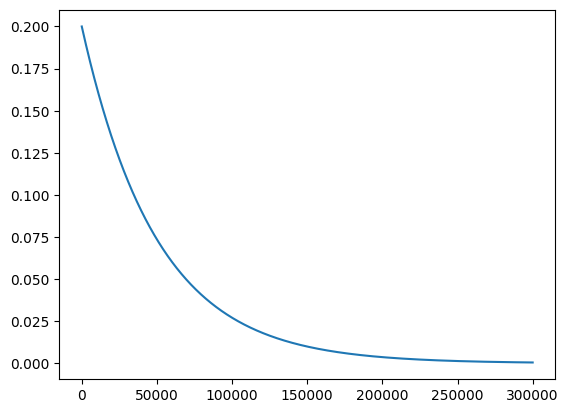

In [20]:
import numpy as np
timesteps=300000
init_lr = 0.2
decay_rate = 0.00002
plt.plot(np.arange(timesteps), [init_lr * ((1 - decay_rate) ** i)for i in range(1, timesteps + 1)])

### E01:
#### *Tune the hyperparameters of the training to beat my best validation loss of 2.2*

After running many different experiments, I was able to improve upon the results in lecture by increasing the minibatch size, and using learning rate decay to gradually reduce the learning rate over the course of training. I think that using a larger minibatch size resulted in smoother convergence than the size 32 batches we used in lecture, which helped us reach a lower loss value. A smooth learning rate decay curve also likely helped with this:

In [21]:
emb_size = 10
block_size = 3
num_chars = len(chars)
hidden_layer_size = 200
X, Y = build_inputs_and_labels(words, block_size)
parameters = init_parameters(num_chars, block_size, emb_size, hidden_layer_size)
losses = gradient_descent(X_train, Y_train, parameters, iterations=300000, minibatch_size=128, lr=0.2, lr_decay=0.00002, regularization=0.01, print_every=10000)

Iteration 0 loss: 27.030107498168945
Iteration 10000 loss: 2.482227325439453
Iteration 20000 loss: 2.1685237884521484
Iteration 30000 loss: 2.3216135501861572
Iteration 40000 loss: 2.086141586303711
Iteration 50000 loss: 2.047783374786377
Iteration 60000 loss: 2.324355125427246
Iteration 70000 loss: 2.263662576675415
Iteration 80000 loss: 2.184842348098755
Iteration 90000 loss: 2.204026460647583
Iteration 100000 loss: 2.268047571182251
Iteration 110000 loss: 2.125098466873169
Iteration 120000 loss: 2.3255839347839355
Iteration 130000 loss: 2.132024049758911
Iteration 140000 loss: 2.256807327270508
Iteration 150000 loss: 2.1870903968811035
Iteration 160000 loss: 2.038959264755249
Iteration 170000 loss: 2.285935163497925
Iteration 180000 loss: 2.2013797760009766
Iteration 190000 loss: 2.1849381923675537
Iteration 200000 loss: 2.0937795639038086
Iteration 210000 loss: 2.248771905899048
Iteration 220000 loss: 2.144094228744507
Iteration 230000 loss: 2.1325316429138184
Iteration 240000 loss

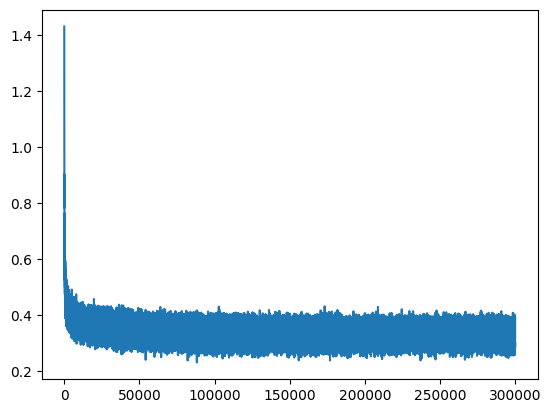

In [22]:
plt.plot(torch.tensor(losses).log10())

We can see that the train and validation losses are both improvements over our results in lecture:

In [23]:
def evaluate(x, y, parameters):
    logits = forward(x, parameters)
    loss = torch.nn.functional.cross_entropy(logits, y)
    return loss.item()

In [24]:
evaluate(X_train, Y_train, parameters)

2.1336007118225098

In [25]:
evaluate(X_dev, Y_dev, parameters)

2.1923234462738037

Finally, when we try the data on the test set, we acheive a similar result to validation. (If we hadn't we may have accidentally overfit to the validation set via tuning hyperparameters.)

In [26]:
evaluate(X_test, Y_test, parameters)

2.184178113937378

We can generate some names with the trained model to verify the model works well:

I added some features to the generate function that allows the user to specify a minimum and maximum length!

In [27]:
def generate(parameters, block_size, min_chars=3, max_chars=20):
    C, W1, b1, W2, b2 = parameters
    context = [0] * block_size
    out = []
    for i in range(max_chars):
        logits = forward(torch.tensor([context]), parameters)
        probs = torch.nn.functional.softmax(logits, dim=1)
        if i < min_chars:
            probs[0, 0] = 0
        ix = torch.multinomial(probs, 1).item()
        if ix == 0:
            break
        out.append(itos[ix])
        context = context[1:] + [ix]

    return ''.join(out)

In [28]:
for i in range(20):
    print(generate(parameters, 3))

arso
onitlyn
amiliah
khagy
masia
sur
kenikona
brie
fazoli
raylon
dysceld
beyliah
aayven
ario
taman
abitabron
imley
herraelan
duccaar
simanahsin


For fun, we can try to generate some really long names:


In [29]:
for i in range(20):
    print(generate(parameters, 3, min_chars=12, max_chars=40))

korielleyani
nassinanieneen
zaxreimaniah
neenaredeman
colenisanish
camaizaleena
greneusiahar
faizleeniacotn
jalidynneeaj
thgotturtleit
huanaleeshaycent
kaidardonalee
julyvinthive
ondennalungrennaymalu
neighlynnlee
keusynleighorathira
morionancess
zoenneyarthovajth
lyleighliviannaleightare
cashaxtaebuble


### E02:
#### *I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?*

If the predicted probabilities were perfectly uniform, per the log-likelihood formula the loss would be -log(1/27), given a dataset with 27 characters.

We can verify that this is the case:

In [30]:
y_actual = Y_train[0]
y_actual

tensor(18)

In [31]:
logits = torch.ones(27).divide(27)
logits

tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

We'd also apply a softmax activation, but it results in the exact same logits if the logits are all the same.

In [32]:
torch.nn.functional.softmax(logits, dim=0)

tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

So it really doesn't matter what value the weights hold. However, the tanh activation is more informative when values are close to zero, so we should strive to keep the weights closer to zero (rather than say, initialize them all to 10000000).

In [33]:
torch.nn.functional.cross_entropy(logits, y_actual)

tensor(3.2958)

In [34]:
import math
-math.log(1/27)

3.295836866004329

Our starting loss is much higher (~23!). To acheive a similar loss, we could make every weight and bias uniform across layers throughout the network. Before, we sampled weights between 0 and 1. To acheive a starting loss of -log(1/27), we can initialize them all to the same value, 0.5 sounds appropriate given that it's in the center of our previous distribution.


In [35]:
def init_parameters(num_chars, block_size, embedding_size, hidden_layer_size):
    C = torch.full((num_chars, embedding_size), 0.5, requires_grad=True)
    W1 = torch.full((embedding_size * block_size, hidden_layer_size), 0.5, requires_grad=True)
    b1 = torch.full((hidden_layer_size,), 0.5, requires_grad=True)
    W2 = torch.full((hidden_layer_size, num_chars), 0.5, requires_grad=True)
    b2 = torch.full((num_chars,), 0.5, requires_grad=True)

    return [C, W1, b1, W2, b2]

In [36]:
new_parameters = init_parameters(num_chars, block_size, emb_size, hidden_layer_size)

In [37]:
new_parameters[0][:3]

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000]], grad_fn=<SliceBackward0>)

And we can verify that we acheive the desired starting loss:

In [38]:
evaluate(X_train, Y_train, new_parameters)

3.29583740234375

### E03:
#### *Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?*

One idea we could try from the paper is mixing n-gram (in this case, trigram) probabilities with the neural network probabilities to get a final probability, s.t. with each probability having a weight of 0.5. In their results, the network consistently performed better with this technique. The authors suggested that this suggests that the trigram and neural network models tend to make errors in different places.

To acheive this, we can first instantiate and populate a trigram matrix. It's probably prudent just to compute this on the training dataset rather than the entire dataset.

In [39]:
trigrams = torch.zeros((27 * 27), 27)

for word in train_words:
    ids = ([0] * (block_size - 1)) + [stoi[c] for c in word] + [0]
    for i in range(len(ids) - 2):
        trigrams[(ids[i] * 27) + ids[i + 1], ids[i + 2]] += 1

trigrams = (trigrams / trigrams.sum(dim=1, keepdim=True)).nan_to_num(nan=0.0)

Next, we can update the evaluation function to average the network output and the trigram output.

In [40]:
def evaluate(x, y, parameters, trigrams):
    logits = forward(x, parameters)
    preds = (torch.softmax(logits, dim=1) * 0.5) + (torch.softmax(trigrams[x[:, 1] * 27 + x[:, 2]], dim=1) * 0.5)
    loss = -preds[torch.arange(y.shape[0]), y].log().mean()

    return loss.item()

In [41]:
evaluate(X_train, Y_train, parameters, trigrams)

2.39650559425354

In [42]:
evaluate(X_dev, Y_dev, parameters, trigrams)

2.423555612564087

This technique does not improve our model's performance. Perhaps this technique tends to work better on word-level models like in the paper rather than character-level models -- perhaps because the embeddings needed to properly represent a letter are much simpler than those for a word, meaning that ensambling our neural network with the trigram model does not compensate for any of the neural network's error.

We could also try introducing the trigram mixing into our training loop, but I am skeptical:

In [43]:
def optimize_step(x, y, parameters, trigrams, lr=0.1):
    logits = forward(x, parameters)
    preds = (torch.softmax(logits, dim=1) * 0.5) + (torch.softmax(trigrams[x[:, 1] * 27 + x[:, 2]], dim=1) * 0.5)
    loss = -preds[torch.arange(y.shape[0]), y].log().mean()
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr
        p.grad = None
    return loss.item()

def gradient_descent(x, y, parameters, trigrams, iterations=100, minibatch_size=100, lr=0.1, lr_decay=0.001, regularization=0.01, print_every=10):
    losses = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        reg_term = torch.sum(torch.stack([(p**2).sum() for p in parameters])).divide(torch.sum(torch.tensor([p.numel() for p in parameters]))) * regularization
        loss = optimize_step(xi, yi, parameters, trigrams, lr) + reg_term
        losses.append(loss)
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr = lr * (1 - lr_decay)
    return losses


In [44]:
new_parameters = init_parameters(num_chars, block_size, emb_size, hidden_layer_size)
losses = gradient_descent(X_train, Y_train, new_parameters, trigrams, iterations=300000, minibatch_size=128, lr=0.2, lr_decay=0.00002, regularization=0.01, print_every=10000)

Iteration 0 loss: 3.2355258464813232
Iteration 10000 loss: 2.9912023544311523
Iteration 20000 loss: 2.890807867050171
Iteration 30000 loss: 2.9454662799835205
Iteration 40000 loss: 2.779658317565918
Iteration 50000 loss: 2.953145742416382
Iteration 60000 loss: 2.850191354751587
Iteration 70000 loss: 2.913511276245117
Iteration 80000 loss: 2.838305711746216
Iteration 90000 loss: 2.9425413608551025
Iteration 100000 loss: 2.8394775390625
Iteration 110000 loss: 2.8571293354034424
Iteration 120000 loss: 2.822970151901245
Iteration 130000 loss: 2.7861061096191406
Iteration 140000 loss: 2.9053704738616943
Iteration 150000 loss: 2.9254987239837646
Iteration 160000 loss: 2.792872190475464
Iteration 170000 loss: 2.907606363296509
Iteration 180000 loss: 2.861936330795288
Iteration 190000 loss: 2.8617069721221924
Iteration 200000 loss: 2.7407641410827637
Iteration 210000 loss: 2.8845911026000977
Iteration 220000 loss: 2.837003231048584
Iteration 230000 loss: 2.897488832473755
Iteration 240000 loss

After many iterations with no signs of life, I decided to stop training early.

In [45]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

#### E04:
I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net.
You might think either that
1) the network trains just fine or
2) the network doesn't train at all

but actually it is:

the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

We can start by modifying our Linear Module to initialize its weights and biases to zeros:

In [46]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weights = torch.zeros((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x): # 'forward'
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights, self.bias] if self.bias is not None else [self.weights]

class Tanh:
    def __init__(self) -> None:
        pass

    def __call__(self, x):
        self.out = x.tanh()
        return self.out

    def parameters(self):
        return []

Next we can construct a network and inspect the gradients and activations:

In [48]:
# dataset stuff

words = open('names.txt').read().splitlines()
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}

def build_inputs_and_labels(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

def train_dev_test_split(words, train_size=0.8, dev_size=0.1):
    random.shuffle(words)
    assert train_size + dev_size < 1
    num_words = len(words)
    train_split = int(num_words * train_size)
    dev_split = int(num_words * (train_size + dev_size))
    train_words = words[:train_split]
    dev_words = words[train_split:dev_split]
    test_words = words[dev_split:]
    return train_words, dev_words, test_words


train_words, dev_words, test_words = train_dev_test_split(words)
block_size = 3
embedding_size = 10
hidden_layer_size = 100
num_chars = len(chars)
train_X, train_Y = build_inputs_and_labels(train_words, block_size=3)

In [49]:
embeddings = torch.randn((num_chars, embedding_size))
layers = [
    Linear(embedding_size * block_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, num_chars)
]

parameters = [embeddings] + [p for layer in layers for p in layer.parameters()]
print(f'Number of Parameters: {sum(p.numel() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

Number of Parameters: 46497


Next, we can try running gradient descent for a few iterations to see what our gradients and activations look like using the techniques from lecture:

In [50]:
def forward(layers, embeddings, x):
    x = embeddings[x]
    x = x.view(x.shape[0], -1)
    for layer in layers:
        x = layer(x)
    return x

def optimize_step(x, y, layers, embeddings, parameters, lr, debug=False):
    for p in parameters:
        p.grad = None
    logits = forward(layers, embeddings, x)
    loss = torch.nn.functional.cross_entropy(logits, y)

    if debug:
        for layer in layers:
            layer.out.retain_grad()
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr

    return loss.item()

def gradient_descent(x, y, layers, embeddings, parameters, iterations, minibatch_size, lr, lr_decay, print_every, debug=False):
    losses = []
    ud = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        loss = optimize_step(xi, yi, layers, embeddings, parameters, lr, debug)
        losses.append(loss)
        with torch.no_grad():
            ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in parameters])
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr *= (1 - lr_decay)
    return losses, ud

In [51]:
losses, ud = gradient_descent(train_X, train_Y, layers, embeddings, parameters, iterations=1000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000, debug=True)

Iteration 0 loss: 3.295837163925171


We can see our loss decreases over the first few iterations, but does not converge to a value as low as other iterations of our model have converged to:

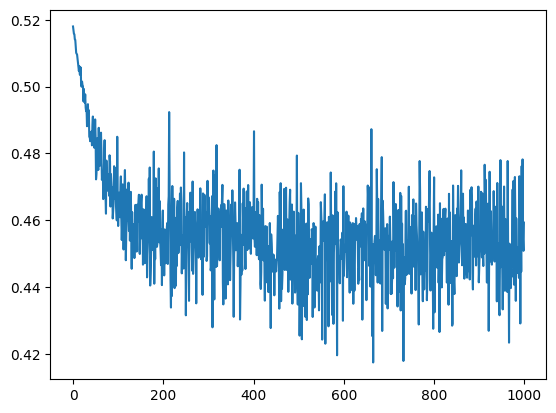

In [52]:
plt.plot(torch.tensor(losses).log10())
plt.show()

Let's figure out why our model is not training as well. To start, we can look at the activations coming out of each tanh layer, just as we did in lecture:

Layer 1 mean=+0.00, stddev=0.00, saturation=0.00%
Layer 3 mean=+0.00, stddev=0.00, saturation=0.00%
Layer 5 mean=+0.00, stddev=0.00, saturation=0.00%
Layer 7 mean=+0.00, stddev=0.00, saturation=0.00%
Layer 9 mean=+0.00, stddev=0.00, saturation=0.00%


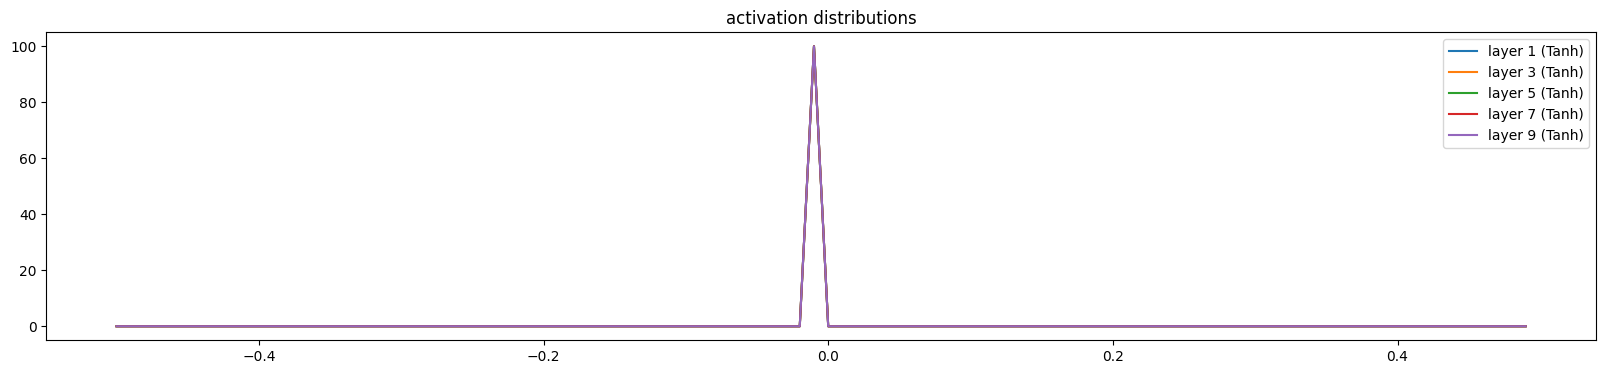

In [53]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f'Layer {i} mean={t.mean():+.2f}, stddev={t.std():.2f}, saturation={(t.abs() > 0.97).float().mean()*100:.2f}%'
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distributions')
plt.show()

We can see that every single activation is zero... no wonder our network is not training well. But if all the tanh activations are zero, how is our network training at all? We did see loss go down, so something must be happening in the final layer.

Layer 9 mean=+0.00, stddev=0.00, saturation=0.00%


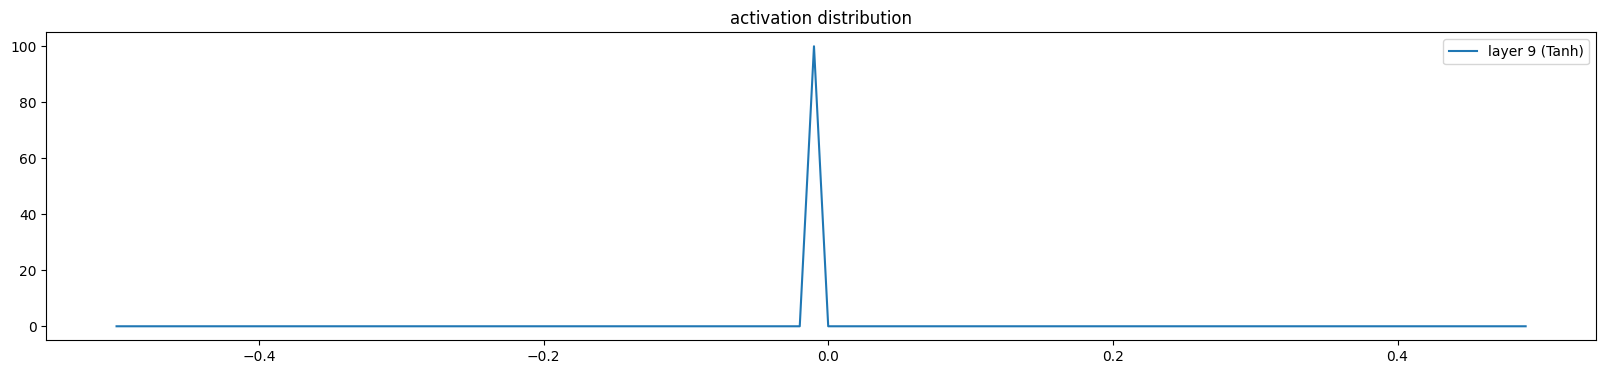

In [54]:
plt.figure(figsize=(20, 4))
legends = []
t = layer.out
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
legends.append(f'layer {i} ({layer.__class__.__name__})')
print(
    f'Layer {i} mean={t.mean():+.2f}, stddev={t.std():.2f}, saturation={(t.abs() > 0.97).float().mean()*100:.2f}%'
)
plt.legend(legends)
plt.title('activation distribution')
plt.show()

We do see activations in this layer... let's check the gradients to get a better idea of what's going on:

weight shape=torch.Size([100, 27]) mean=+0.00000, stddev=0.00000, grad:data ratio=nan


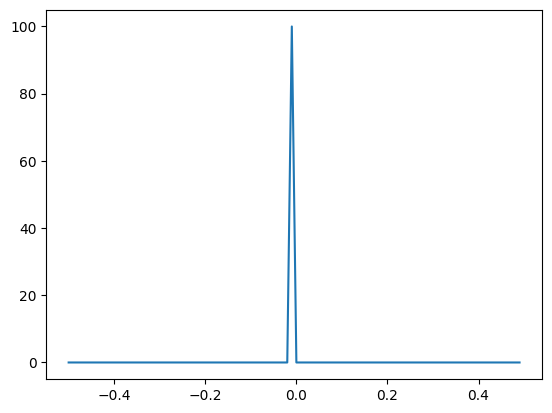

In [55]:
final_layer_weights, final_layer_bias = parameters[-2], parameters[-1]
t = final_layer_weights.grad
print(f'weight shape={final_layer_weights.shape} mean={t.mean():+.5f}, stddev={t.std():.5f}, grad:data ratio={(t.std() / final_layer_weights.std()):.5f}')
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
legends.append(f'{i} {tuple(final_layer_weights.shape)}')


The layer's weights all have zero gradient, so something *must* be going on with the bias parameters...

weight shape=torch.Size([27]) mean=-0.00000, stddev=0.01557, grad:data ratio=0.01510


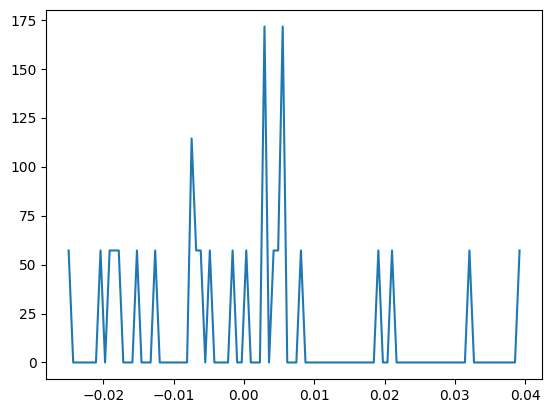

In [56]:
t = final_layer_bias.grad
print(f'weight shape={final_layer_bias.shape} mean={t.mean():+.5f}, stddev={t.std():.5f}, grad:data ratio={(t.std() / final_layer_bias.std()):.5f}')
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
legends.append(f'{i} {tuple(final_layer_bias.shape)}')

Sure enough, the only signs of life in the network are in the bias parameters. Since these are the only paramters with gradient, our network is essentially learning a constant function y = b. If this is truly the case, we'd expect the network to learn to always pick the most common letters. Furthermore, we'd expect every network output to be identical regardless of input. We can verify:

In [57]:
forward(layers, embeddings, train_X[0:5])

tensor([[ 1.7558,  1.8474, -0.7040, -0.3164,  0.0675,  1.3981, -1.3612, -0.9164,
          0.3487,  1.2642, -0.5838, -0.0278,  1.0283,  0.2435,  1.2389,  0.4197,
         -1.2858, -1.6630,  0.8910,  0.4232,  0.0474, -0.4927, -0.7057, -1.3868,
         -1.4177,  0.6287, -0.7409],
        [ 1.7558,  1.8474, -0.7040, -0.3164,  0.0675,  1.3981, -1.3612, -0.9164,
          0.3487,  1.2642, -0.5838, -0.0278,  1.0283,  0.2435,  1.2389,  0.4197,
         -1.2858, -1.6630,  0.8910,  0.4232,  0.0474, -0.4927, -0.7057, -1.3868,
         -1.4177,  0.6287, -0.7409],
        [ 1.7558,  1.8474, -0.7040, -0.3164,  0.0675,  1.3981, -1.3612, -0.9164,
          0.3487,  1.2642, -0.5838, -0.0278,  1.0283,  0.2435,  1.2389,  0.4197,
         -1.2858, -1.6630,  0.8910,  0.4232,  0.0474, -0.4927, -0.7057, -1.3868,
         -1.4177,  0.6287, -0.7409],
        [ 1.7558,  1.8474, -0.7040, -0.3164,  0.0675,  1.3981, -1.3612, -0.9164,
          0.3487,  1.2642, -0.5838, -0.0278,  1.0283,  0.2435,  1.2389,  0.4197

Our intuition was correct!

And sure enough...

In [58]:
forward(layers, embeddings, train_X[0:5])[0].argmax(dim=-1)

tensor(1)

In [59]:
counts = torch.zeros(num_chars)
for word in train_words:
    for c in word:
        counts[stoi[c]] += 1
print(itos[torch.argmax(counts).item()])

a


The most likely character simply becomes the most common one in the dataset!

But why are the output layer biases the only parameters with any gradient?

Well...if we calculate the gradient of the final layer's weights, for a particular weight w the gradient becomes x (value of input) by the definition $\frac{d}{dw}w*x = x$, multiplied by the gradient of the loss function. Since the input value is zero, the gradient for each of the output layer weights becomes zero. Then... this gradient propogates back and since we are only using products and tanh throughout the network makes the gradients for each of the other linear layers zero. This phenomenon persists indefinitely because zero of the final output paramters can learn. This goes to show the importance of initializing weights to nonzero values in order to allow gradient to propogate. Even if we initialized the embeddings to nonzero values the phenomenon would persist.

### E05:
BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

Let's review our batchnorm implementation from lecture:

In [60]:
class BatchNorm:
    def __init__(self, dim, eps=1e-6, momentum=0.1, training=True) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = training

        # gain and bias (gamma and beta)
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)

        # running mean and variance
        self.running_mean = torch.zeros(dim)
        self.running_variance = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            mean = x.mean(0, keepdim=True)
            variance = x.var(0, keepdim=True)
        else:
            mean = self.running_mean
            variance = self.running_variance

        xout = (x - mean) / torch.sqrt(variance + self.eps)
        self.out = (xout * self.gain) + self.bias

        if self.training:
            with torch.no_grad():
                self.running_mean = ((1 - self.momentum) * self.running_mean) + (self.momentum * mean)
                self.running_variance = ((1 - self.momentum) * self.running_variance) + (self.momentum * variance)

        return self.out

    def parameters(self):
        return [self.gain, self.bias]


We can see that during inference, our batchnorm layer output is given by

$out=g_n * (\frac{(x-\mu)}{\sqrt{v + \epsilon}}) + b_n$

Then, substituting our previous layer's math, we get:

$out=g_n * (\frac{(w*x + b)-\mu)}{\sqrt{v + \epsilon}}) + b_n$

Which we can simplify to:


$out=(g_n * \frac{w}{\sqrt{v + \epsilon}}) * x + (g_n * \frac{b-\mu}{\sqrt{v + \epsilon}} + b_n)$

Which implies that in order to 'fold in' the batch normalization layer,

$w_2= (g_n * \frac{w}{\sqrt{v + \epsilon}}) $ and

$b_2= (g_n * \frac{b-\mu}{\sqrt{v + \epsilon}} + b_n)$

This becomes fairly trivial to implement:


In [61]:
def fold_in(linear_layer: Linear, batchnorm_layer: BatchNorm) -> Linear:
    linear_layer.weights.data = batchnorm_layer.gain.data * (linear_layer.weights.data / torch.sqrt(batchnorm_layer.running_variance + batchnorm_layer.eps))
    linear_layer.bias.data = batchnorm_layer.gain.data * ((linear_layer.bias.data - batchnorm_layer.running_mean) / torch.sqrt(batchnorm_layer.running_variance + batchnorm_layer.eps)) + batchnorm_layer.bias.data

    return linear_layer

Then, given a simple MLP network, we can show that the two are equivalent:

In [62]:
embeddings = torch.randn((num_chars, embedding_size))
layers = [
    Linear(embedding_size * block_size, hidden_layer_size),
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, num_chars)
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3 # kaiming gain for tanh
    layers[-1].weights *= 0.1

parameters = [embeddings] + [p for layer in layers for p in layer.parameters()]
print(f'Number of Parameters: {sum(p.numel() for p in parameters)}')
for p in parameters:
    p.requires_grad = True
# train it for a few iterations so we establish running mean and variance
losses, ud = gradient_descent(train_X, train_Y, layers, embeddings, parameters, iterations=1000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000, debug=True)

Number of Parameters: 26897
Iteration 0 loss: 3.295837163925171


In [63]:
result_1 = forward(layers, embeddings, train_X[0:5])

In [64]:
folded_layers = [
    fold_in(layers[0], layers[1]),
    Tanh(),
    fold_in(layers[3], layers[4]),
    Tanh(),
    fold_in(layers[6], layers[7]),
    Tanh(),
    layers[9]
]

In [65]:
result_2 = forward(folded_layers, embeddings, train_X[0:5])

In [66]:
torch.eq(result_1, result_2).all()

tensor(True)

*Voila!*